In [1]:
EMULATORS_PATH = "/Users/gabe/projects/emulators/src"
RECOMBINATION_PATH = "/Users/gabe/projects/recombination/src" 

import sys
import os
import numpy as np
from scipy.interpolate import CubicSpline
import classy as Class

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

import scipy.special
from scipy.stats import logistic
from scipy.optimize import fsolve

if EMULATORS_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/emulators/src")
if RECOMBINATION_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/recombination/src")
from TrainedEmulator import *
from ChainTools import *

from getdist import plots, MCSamples, loadMCSamples

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

2023-09-09 14:43:01.447958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
planck_best_fit_cosmo = {"omega_b": 0.0223828,
                         "omega_cdm": 0.1201075,
                         "tau_reio": 0.05430842, 
                         "ln10^{10}A_s": 3.044784,
                         "n_s": 0.9660499,
                         "H0": 67.32117}

qi_priors = {"q_1": [-3.5, 3.5],
            "q_2": [-1, 1],
            "q_3": [-3.5, 3.5],
            "q_4": [-1.5, 1.5],
            "q_5": [-6.5, 6.5]}

def create_cp_string(list_of_control_points):

    list_of_control_points = np.insert(list_of_control_points, 0, 0.0)
    list_of_control_points = np.append(list_of_control_points, 0.0)
    str_ctrl = ["{:.4f}".format(c) for c in list_of_control_points]
    str_ctrl = ",".join(str_ctrl)

    return str_ctrl

common_settings = {'output' : 'tCl,pCl,lCl,mPk',
                   # LambdaCDM parameters
                   'H0':planck_best_fit_cosmo["H0"],
                   'omega_b':planck_best_fit_cosmo["omega_b"],
                   'omega_cdm':planck_best_fit_cosmo["omega_cdm"],
                   'ln10^{10}A_s': planck_best_fit_cosmo["ln10^{10}A_s"],
                   'n_s':planck_best_fit_cosmo["n_s"],
                   'tau_reio': planck_best_fit_cosmo["tau_reio"],
                  }

precision_settings = {'N_ur': 2.0308,
		  'N_ncdm': 1,
		  'm_ncdm': 0.06,
		  'T_ncdm': 0.71611, #1 species of massive neutrinos
          'lensing': 'yes',
		  'accurate_lensing': 1.0,
		  'k_max_tau0_over_l_max': 15.00,
		  'P_k_max_1/Mpc':  500.0,
		  'perturbations_sampling_stepsize': 0.05,
		  #'non_linear': 'hmcode',
		  #'eta_0': 0.603,
		  #'c_min': 3.130,
		  'l_max_scalars': 8000,
		  'xe_pert_type': 'none',
          'start_sources_at_tau_c_over_tau_h': 0.004}
          
M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
M.compute()

thermo_fid = M.get_thermodynamics()
xe_func_fid = interp1d(thermo_fid["z"], thermo_fid["x_e"])
Yp = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max_fid = 1 + Yp/2*(1-Yp)

cls_fid = M.lensed_cl()

# Outlier hunting

In [4]:
datadir = "/Users/gabe/projects/emulators/data/modrec_new"

y_ranges = {"tt": [0, 1.5e-9],
            "ee": [0, 1e-11],
            "te": [-4e-11, 4e-11],
            "pp": [1e-9, 2e-7]}

fine_grid = np.linspace(2, 5000, 1000)

trajectory_dict = {}

for q in ["tt", "te", "ee", "pp"]:
    with open(os.path.join(datadir, "N-50000/Cl_"+q+".txt"), "r") as f:
        i=0
        out_list = []
        for line in f:
            if i==0:
                ell = np.array([int(l) for l in line.split("\t")])
            else:
                out_list.append(np.array([float(cl) for cl in line.split("\t")]))
            i+=1
        out_list = np.vstack(out_list)
        if q=="pp":
            trajectories = np.vstack([CubicSpline(ell, (ell*(ell+1))*y, extrapolate=True)(fine_grid) for y in out_list])
        else:
            trajectories = np.vstack([CubicSpline(ell, y, extrapolate=True)(fine_grid) for y in out_list])
        trajectory_dict[q] = trajectories

In [5]:

outlier_indices = {}
masking_arrs = {}
## tt
x_index = 100
y_cutoff = 1e-9

out_index = []
for i,t in enumerate(trajectory_dict["tt"]):
    if (t[x_index:]>y_cutoff).any() or (t[10]>y_cutoff) or (t[0:10]>0.5e-9).any():
        out_index.append(i)
outlier_indices["tt"] = np.array(out_index)
mask = np.vectorize(lambda x: False if x in outlier_indices["tt"] else True)
masking_arrs["tt"]=mask(np.arange(0, trajectory_dict["tt"].shape[0]))
## pp
x_index = 0
y_cutoff = 3e-7

out_index = []
for i,t in enumerate(trajectory_dict["pp"]):
    if (t[x_index:]>y_cutoff).any():
        out_index.append(i)
outlier_indices["pp"] = np.array(out_index)
mask = np.vectorize(lambda x: False if x in outlier_indices["pp"] else True)
masking_arrs["pp"]=mask(np.arange(0, trajectory_dict["pp"].shape[0]))

In [6]:
quantity = "tt"
trajectories = trajectory_dict[quantity]
y_range = y_ranges[quantity]
h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=1000)

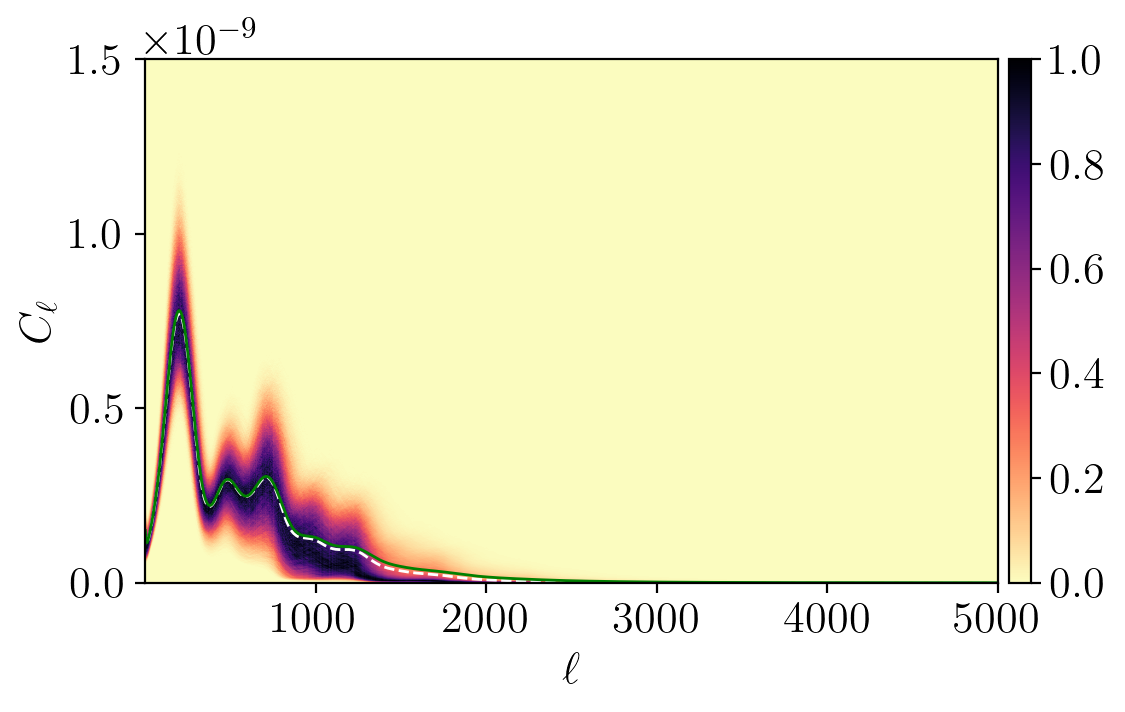

In [8]:
fig,ax = plt.subplots() 
fig.set_size_inches(w=5.5, h=3.4)

m=ax.imshow(h, cmap=mpl.cm.get_cmap('magma_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")

#for t in trajectories[outlier_indices["tt"]]:
#    ax.plot(fine_grid, t, alpha=0.05, color="black")

ax.plot(fine_grid,np.median(trajectories, axis=0), color="white", linewidth=1, linestyle="dashed")
#ax.plot(fine_grid,np.mean(trajectories, axis=0), color="red", linewidth=1, linestyle="dashed")
ax.plot(fine_grid,np.mean(trajectories[masking_arrs["tt"]], axis=0), color="green", linewidth=1, linestyle="solid")

#temp_fid = CubicSpline(cls_fid["ell"][2:], cls_fid[quantity][2:])(fine_grid)
#ax.plot(fine_grid, fine_grid*(fine_grid+1)/(2*np.pi)*temp_fid, color="lightsteelblue")

#ax.set_title(chain_name)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell$")
ax.set_ylim(y_range)
#ax.set_yscale("log")
#ax.set_xscale("log")
#ax.set_xlim([0,200])


plt.colorbar(m, cax=cax)
#plt.savefig("../results/delta_xe_2p5sigma.png",dpi=300, bbox_inches='tight')

In [9]:
print(outlier_indices["pp"])
print(outlier_indices["tt"])

for p in outlier_indices["tt"]:
    if p not in outlier_indices["pp"]:
        print(p)

total_ind_to_delete = np.array(list(set(outlier_indices["tt"]) | set(outlier_indices["pp"])))
total_ind_to_delete = np.sort(total_ind_to_delete)+1
print(len(total_ind_to_delete))
print(total_ind_to_delete)
print(fine_grid[20])

[]
[]
0
[]
102.06006006006005


## Parameter space 

In [38]:
dirs = ["number_2", "number_3", "number_4", "number_5"]
model_file = "model_params.txt"

model_dict = {}
for d in dirs:
    with open(os.path.join(datadir, d, model_file), "r") as f:
        i=0
        models = []
        for line in f:
            if i==0:
                param_names = line.strip().split("\t")
            else:
                models.append(np.array([float(p) for p in line.split("\t")]))
            i+=1
        model_dict[d] = np.vstack(models)
        param_names[0] = "omega_b"

new_points = []
running_total = 0
i=0
for name, mlist in model_dict.items():
    current = len(mlist) - running_total
    new_points.append(current)
    running_total = len(mlist)

for i,name in enumerate(model_dict.keys()):
    total = len(model_dict[name])
    model_dict[name] = model_dict[name][(total-new_points[i]):total]

print(len(model_dict["number_2"]))
print(len(model_dict["number_3"]))
print(len(model_dict["number_4"]))
print(len(model_dict["number_5"]))

20000
8710
5244
4269


In [39]:
print(param_names)

['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5']


('omega_b', 'omega_cdm')
('omega_b', 'n_s')
('omega_b', 'tau_reio')
('omega_b', 'ln10^{10}A_s')
('omega_b', 'H0')
('omega_cdm', 'n_s')
('omega_cdm', 'tau_reio')
('omega_cdm', 'ln10^{10}A_s')
('omega_cdm', 'H0')
('n_s', 'tau_reio')
('n_s', 'ln10^{10}A_s')
('n_s', 'H0')
('tau_reio', 'ln10^{10}A_s')
('tau_reio', 'H0')
('ln10^{10}A_s', 'H0')


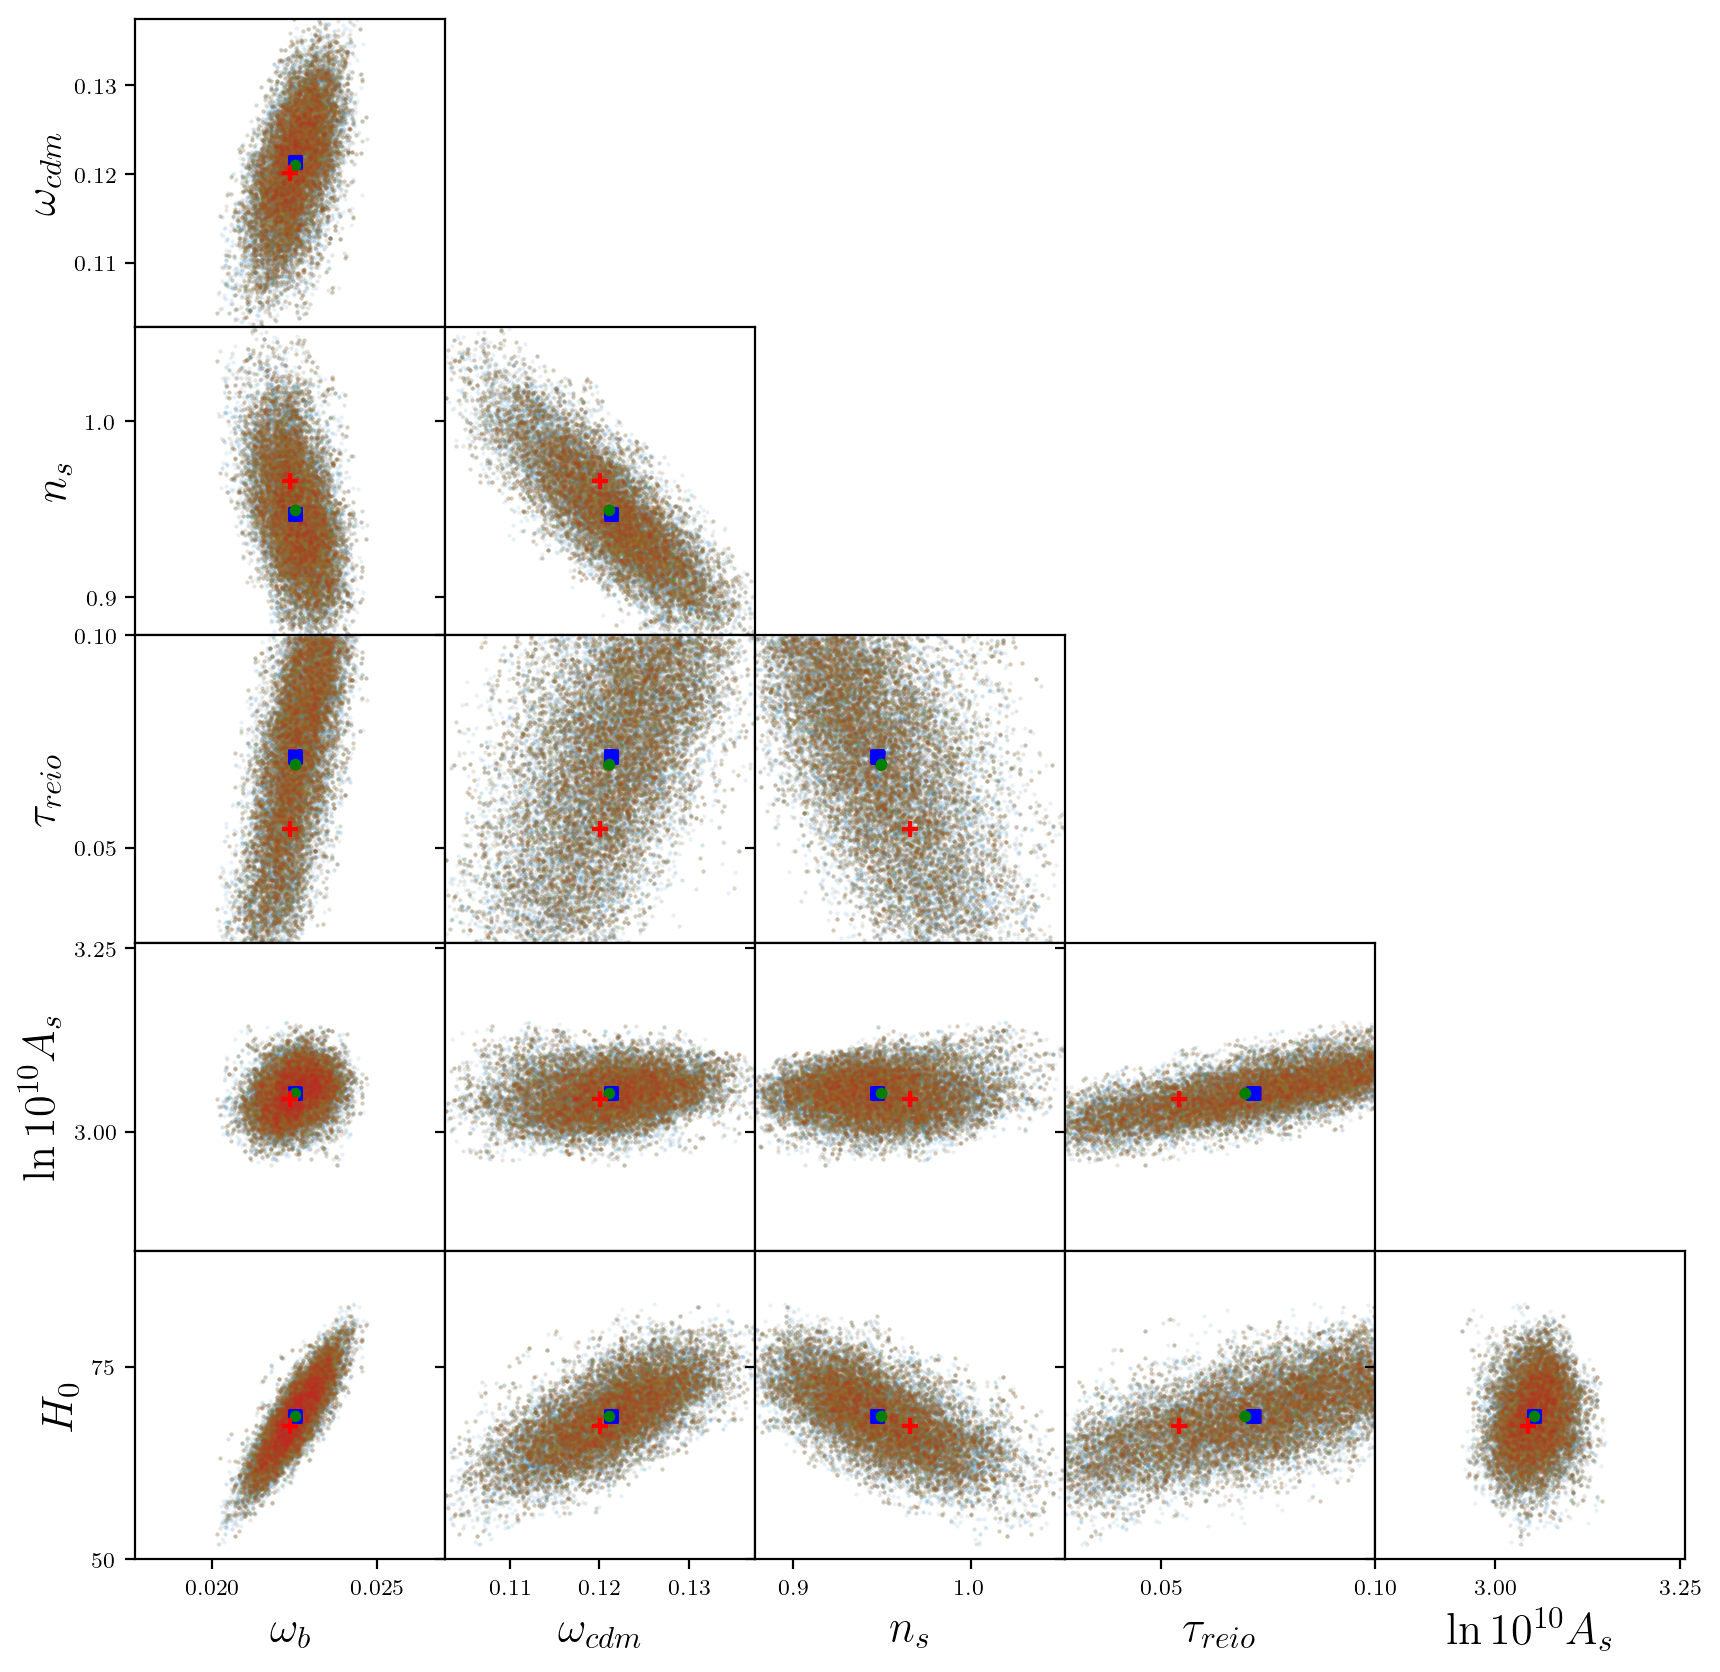

In [41]:
import itertools
params_to_plot = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
#params_to_plot = ['q_1', 'q_2', 'q_3', 'q_4', 'q_5']
label_dict = {'omega_b': '\omega_b', 
              'omega_cdm': '\omega_{cdm}',
              'n_s': 'n_s',
              'tau_reio': '\\tau_{reio}',
              'ln10^{10}A_s': '\ln10^{10}A_s',
              'H0': "H_0",
              "q_1": "q_1",
              "q_2": "q_2",
              "q_3": "q_3",
              "q_4": "q_4",
              "q_5": "q_5"}

planck_best_fit_list_modrec = {"omega_b": 0.0223828,
                         "omega_cdm": 0.1201075,
                         "tau_reio": 0.05430842, 
                         "ln10^{10}A_s": 3.044784,
                         "n_s": 0.9660499,
                         "H0": 67.32117,
                         "q_1": 0.0,
                         "q_2": 0.0,
                         "q_3": 0.0,
                         "q_4": 0.0,
                         "q_5": 0.0}

boundaries = {"omega_b": [0.017679929999875305, 0.027074810000124697],
            "omega_cdm": [0.10277449520012398, 0.137432504799876],
            "n_s": [0.8784417847140357, 1.0533428152859643],
            "tau_reio": [0.0276, 0.1],
            "ln10^{10}A_s": [2.837, 3.257],
            "H0": [50, 90],
            "q_1": [-1.1067021150891954, 9.04413638849538],
            "q_2": [-2.8265865397486443, 7.324251963835911],
            "q_3": [-4.2051937087004525, 5.945644794884151],
            "q_4": [-5.444094011704111, 4.706744491880487],
            "q_5": [-6.742402816593671, 3.408435686992014]}

param_combos = list(itertools.combinations(params_to_plot, 2))
#params_to_plot = ["omega_b", "omega_cdm", "H0", "tau_reio", "n_s", "ln10^{10}A_s"]
n = len(params_to_plot)-1
fig,axes = plt.subplots(n, n, figsize=(10,10), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(n):
    for j in range(n):
#        axes[i,j].text(0.5,0.5, "({},{})".format(i,j), transform=axes[i,j].transAxes)
         if(i<j):
            axes[i,j].axis('off')
            continue

thinning = 1
out_index_type = "tt"
for c in param_combos:
    names = c
    print(names)
    i = params_to_plot.index(names[0])
    j = params_to_plot.index(names[1])-1
    for name, models in model_dict.items():
        axes[j,i].scatter(models[::thinning, param_names.index(names[0])], models[::thinning, param_names.index(names[1])], s=1, marker=".", label=name, alpha=0.1)
        axes[j,i].scatter(np.median(models[:, param_names.index(names[0])]), np.median(models[:, param_names.index(names[1])]), s=20, marker="s", color="blue", alpha=1)
        #axes[j,i].scatter(np.mean(models[masking_array, param_names.index(names[0])]), np.mean(models[masking_array, param_names.index(names[1])]), s=10, marker="o", color="green", alpha=1)
        axes[j,i].scatter(np.mean(models[:, param_names.index(names[0])]), np.mean(models[:, param_names.index(names[1])]), s=10, marker="o", color="green", alpha=1)

    #axes[j,i].scatter(models[outlier_indices[out_index_type], param_names.index(names[0])], models[outlier_indices[out_index_type], param_names.index(names[1])], s=10, marker="^", color="purple", alpha=1)
    axes[j,i].scatter(planck_best_fit_list_modrec[names[0]], planck_best_fit_list_modrec[names[1]], marker="+", color="red", alpha=1)

for i in range(n):
    axes[n-1-i,0].set_ylabel("${}$".format(label_dict[params_to_plot[n-i]], fontsize=8))
    axes[n-1-i,0].set_ylim(boundaries[params_to_plot[n-i]])
    axes[n-1-i,0].locator_params(axis='y', nbins=1)
    axes[n-1-i,0].tick_params(axis='y', labelsize=8)
    
    axes[-1, i].set_xlim(boundaries[params_to_plot[i]])
    axes[-1, i].set_xlabel("${}$".format(label_dict[params_to_plot[i]], fontsize=8))
    axes[-1,i].locator_params(axis="x", nbins=1)
    axes[-1,i].tick_params(axis="x", labelsize=8)


## Removing bad indices

In [ ]:
datadir = "/Users/gabe/projects/emulators/data/modrec_new11"
for filename in os.listdir(datadir):
    if filename.endswith(".txt"):
        filename_no_ext = filename.split(".")[0]
        with open(os.path.join(datadir, filename_no_ext+".txt"), "r") as f:
            lines = f.readlines()
        with open(os.path.join(datadir, filename_no_ext+".txt"), "w") as g:
            for i, line in enumerate(lines):
                if i not in total_ind_to_delete:
                    g.write(line)

In [29]:
print(len(model_dict["number_2"]))
print(len(model_dict["number_3"]))

20000
28710
